# **<span style="color:pink;">UK Dataset: Loading and Cleaning</span>**

## **Purpose of Notebook**
Preparing the raw data for EDA, merging datasets, clearning, dropping columns, filling blanks with 'missing', fixing formats etc

## **Problem Statement and Sourcing the Dataset**
Datasets are from:  https://www.gov.uk/government/publications/road-accidents-and-safety-statistics-notes-and-definitions/road-casualty-statistics-overview-and-coverage

Including two different datasets
* Vehicle Incident Data
* Collision Incident Data


This included collsion and vehicle data which is split up into 2 dataset hence a merge based on accident reference is needed to ensure the cells in the US dataset can be found too

---

## **<span style="color:lightblue;">Importing Neccessary Libraries and Modules</span>**

In [3]:
# Import necessary libraries
import pandas as pd # For data manipulation
import itertools
from tabulate import tabulate # For pretty printing tables
import time
from tqdm import tqdm
import reverse_geocode

## **<span style="color:lightblue;">Loading Dataset and Getting Basic Information</span>**


**Loading Datasets into Dataframes**

In [4]:
df_collisions = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK/dft-road-casualty-statistics-collision-last-5-years.csv')
df_vehicles = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK/dft-road-casualty-statistics-vehicle-last-5-years.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK/dft-road-casualty-statistics-collision-last-5-years.csv'

**Finding the Primary Keys for Dataset**

In [ ]:
def find_primary_keys(df):
    """
       Purpose: Finding the primary keys in each dataframe 
       Methods:
         - Check each row for this column is unique (count of column vals = number of rows)
         - If not, then use itertools to experiment with every combination to find what combination is unique
       Input: Dataframe 
       Output: Keys within a string for easy printing
    """
    # Check for single primary key
    for col in df.columns:
        if df[col].is_unique:
            return f"Primary key: ({col})"
    
    # Loop to check every combination
    for i in range(2, len(df.columns) + 1): # keep increasing if no primary key found for double, triple, etc.
        for combo in itertools.combinations(df.columns, i):
            if df[list(combo)].drop_duplicates().shape[0] == df.shape[0]: # check if count = total rows in df
                return f"Primary key: {combo}"
            
    return "No primary key found" # just incase there is no primary key

# Calling Function
print("COLLISIONS: ", find_primary_keys(df_collisions))
print("VEHICLES: ", find_primary_keys(df_vehicles))

COLLISIONS:  Primary key: (accident_index)
VEHICLES:  Primary key: ('accident_index', 'vehicle_reference')


**Merging the vehicle and collision key**

In [ ]:
# common key = 'accident_index' for merging
merged_df = pd.merge(df_collisions, df_vehicles, on='accident_index', how='inner',suffixes=('', '_drop'))
print(tabulate(merged_df.head(10), headers='keys', tablefmt='grid', showindex=True))

+----+------------------+-----------------+----------------------+-------------------------+--------------------------+-------------+------------+----------------+---------------------+----------------------+------------------------+------------+---------------+--------+----------------------------+--------------------------------+---------------------------+--------------------+---------------------+-------------+---------------+-------------------+--------------------+---------------------+----------------------+-------------------------------------+-------------------------------------------+--------------------+----------------------+---------------------------+------------------------------+-----------------------+-----------------------+-----------------------------------------------+-------------------+-----------------------------+-------------------------------+----------------------+---------------------------+---------------------+----------------+---------------------------

**Checking Overall Shape after merge and reducing duplicates**

In [ ]:
print("Shape of df_collisions:", df_collisions.shape)
print("Shape of df_vehicles:", df_vehicles.shape)
print("Shape of df_merged:", merged_df.shape)
merged_df = merged_df.drop_duplicates(subset='accident_index')
print("Removed Duplicates - NEW SHAPE:", merged_df.shape)

Shape of df_collisions: (520084, 37)
Shape of df_vehicles: (953559, 34)
Shape of df_merged: (768171, 70)
Removed Duplicates - NEW SHAPE: (419478, 70)


#### **Summary**
-  Merged based on accident reference and removed the duplicates

---

## **<span style="color:lightblue;">Decoding the normalised data</span>**
- Using the accident index glossary decoding from numbers to the corresponding text values

**Removing Completely Unneeded Columns**

In [ ]:
columns_to_keep = ['accident_index', 'accident_reference', 'latitude', 'longitude', 'location_easting_osgr', 'location_northing_osgr',
                    'accident_severity', 'date', 'time', 'road_type', 'speed_limit', 
                    'light_conditions', 'vehicle_type',
                    'weather_conditions', 'road_surface_conditions', 'vehicle_reference', 'vehicle_manoeuvre', 'hit_object_in_carriageway',
                        'hit_object_off_carriageway', 'first_point_of_impact', 'age_of_vehicle', 'generic_make_model']

merged_df = merged_df[columns_to_keep]

**Mapping the corresponding values**

In [ ]:
# Define mapping dictionaries for each column
# Fill NaN values with -1 for easier mapping
merged_df = merged_df.fillna(-1)
accident_severity_mapping = {
    1: "Fatal",
    2: "Serious",
    3: "Slight"
}

road_type_mapping = {
    1: "Roundabout",
    2: "One way street",
    3: "Dual carriageway",
    6: "Single carriageway",
    7: "Slip road",
    9: "Unknown",
    12: "One way street/Slip road",
    -1: "Missing"
}

light_conditions_mapping = {
    1: "Daylight",
    4: "Darkness - lights lit",
    5: "Darkness - lights unlit",
    6: "Darkness - no lighting",
    7: "Darkness - lighting unknown",
    -1: "Missing"
}

weather_conditions_mapping = {
    1: "Fine no high winds",
    2: "Raining no high winds",
    3: "Snowing no high winds",
    4: "Fine + high winds",
    5: "Raining + high winds",
    6: "Snowing + high winds",
    7: "Fog or mist",
    8: "Other",
    9: "Unknown",
    -1: "Missing"
}

road_surface_conditions_mapping = {
    1: "Dry",
    2: "Wet or damp",
    3: "Snow",
    4: "Frost or ice",
    5: "Flood over 3cm. deep",
    6: "Oil or diesel",
    7: "Mud",
    9: "Unknown",
    -1: "Missing"
}

vehicle_type_mapping = {
    1: "Pedal cycle",
    2: "Motorcycle 50cc and under",
    3: "Motorcycle 125cc and under",
    4: "Motorcycle over 125cc and up to 500cc",
    5: "Motorcycle over 500cc",
    8: "Taxi/Private hire car",
    9: "Car",
    10: "Minibus (8 - 16 passenger seats)",
    11: "Bus or coach (17 or more pass seats)",
    16: "Ridden horse",
    17: "Agricultural vehicle",
    18: "Tram",
    19: "Van / Goods 3.5 tonnes mgw or under",
    20: "Goods over 3.5t. and under 7.5t",
    21: "Goods 7.5 tonnes mgw and over",
    22: "Mobility scooter",
    23: "Electric motorcycle",
    90: "Other vehicle",
    97: "Motorcycle - unknown cc",
    98: "Goods vehicle - unknown weight",
    99: "Unknown",
    -1: "Missing"
}

vehicle_manoeuvre_mapping = {
    1: "Reversing",
    2: "Parked",
    3: "Waiting to go - held up",
    4: "Slowing or stopping",
    5: "Moving off",
    6: "U-turn",
    7: "Turning left",
    8: "Waiting to turn left",
    9: "Turning right",
    10: "Waiting to turn right",
    11: "Changing lane to left",
    12: "Changing lane to right",
    13: "Overtaking moving vehicle - offside",
    14: "Overtaking static vehicle - offside",
    15: "Overtaking - nearside",
    16: "Going ahead left-hand bend",
    17: "Going ahead right-hand bend",
    18: "Going ahead other",
    99: "Unknown",
    -1: "Missing"
}

hit_object_in_carriageway_mapping = {
    0: "None",
    1: "Previous accident",
    2: "Road works",
    4: "Parked vehicle",
    5: "Bridge (roof)",
    6: "Bridge (side)",
    7: "Bollard or refuge",
    8: "Open door of vehicle",
    9: "Central island of roundabout",
    10: "Kerb",
    11: "Other object",
    12: "Any animal (except ridden horse)",
    99: "Unknown",
    -1: "Missing"
}

hit_object_off_carriageway_mapping = {
    0: "None",
    1: "Road sign or traffic signal",
    2: "Lamp post",
    3: "Telegraph or electricity pole",
    4: "Tree",
    5: "Bus stop or bus shelter",
    6: "Central crash barrier",
    7: "Near/Offside crash barrier",
    8: "Submerged in water",
    9: "Entered ditch",
    10: "Other permanent object",
    11: "Wall or fence",
    99: "Unknown",
    -1: "Missing"
}

first_point_of_impact_mapping = {
    0: "Did not impact",
    1: "Front",
    2: "Back",
    3: "Offside",
    4: "Nearside",
    9: "Unknown",
    -1: "Missing"
}

# Replace values in the DataFrame using the mapping dictionaries
merged_df["accident_severity"] = merged_df["accident_severity"].map(accident_severity_mapping)
merged_df["road_type"] = merged_df["road_type"].map(road_type_mapping)
merged_df["light_conditions"] = merged_df["light_conditions"].map(light_conditions_mapping)
merged_df["weather_conditions"] = merged_df["weather_conditions"].map(weather_conditions_mapping)
merged_df["road_surface_conditions"] = merged_df["road_surface_conditions"].map(road_surface_conditions_mapping)
merged_df["vehicle_type"] = merged_df["vehicle_type"].map(vehicle_type_mapping)
merged_df["vehicle_manoeuvre"] = merged_df["vehicle_manoeuvre"].map(vehicle_manoeuvre_mapping)
merged_df["hit_object_in_carriageway"] = merged_df["hit_object_in_carriageway"].map(hit_object_in_carriageway_mapping)
merged_df["hit_object_off_carriageway"] = merged_df["hit_object_off_carriageway"].map(hit_object_off_carriageway_mapping)
merged_df["first_point_of_impact"] = merged_df["first_point_of_impact"].map(first_point_of_impact_mapping)

# Display the first few rows of the updated DataFrame
print("First 10 Rows of df_merged after mapping:")
print(tabulate(merged_df.head(10), headers='keys', tablefmt='grid', showindex=True))

First 10 Rows of df_merged after mapping:
+----+------------------+----------------------+------------+-------------+-------------------------+--------------------------+---------------------+------------+--------+--------------------+---------------+-----------------------+-----------------------+----------------------+---------------------------+---------------------+-------------------------+-----------------------------+------------------------------+-------------------------+------------------+----------------------+
|    |   accident_index |   accident_reference |   latitude |   longitude |   location_easting_osgr |   location_northing_osgr | accident_severity   | date       | time   | road_type          |   speed_limit | light_conditions      | vehicle_type          | weather_conditions   | road_surface_conditions   |   vehicle_reference | vehicle_manoeuvre       | hit_object_in_carriageway   | hit_object_off_carriageway   | first_point_of_impact   |   age_of_vehicle | generic_m

**Only Keeping Car Crashes**

In [ ]:
merged_df = merged_df[merged_df['vehicle_type'] == 'Car']
print("\n🔍 Filtered DataFrame (Only Cars):")
print(tabulate(merged_df.head(10), headers='keys', tablefmt='grid', showindex=True))
print("Shape of car data:", merged_df.shape)


🔍 Filtered DataFrame (Only Cars):
+----+------------------+----------------------+------------+-------------+-------------------------+--------------------------+---------------------+------------+--------+--------------------+---------------+-----------------------+----------------+----------------------+---------------------------+---------------------+-------------------------+-----------------------------+------------------------------+-------------------------+------------------+----------------------+
|    |   accident_index |   accident_reference |   latitude |   longitude |   location_easting_osgr |   location_northing_osgr | accident_severity   | date       | time   | road_type          |   speed_limit | light_conditions      | vehicle_type   | weather_conditions   | road_surface_conditions   |   vehicle_reference | vehicle_manoeuvre       | hit_object_in_carriageway   | hit_object_off_carriageway   | first_point_of_impact   |   age_of_vehicle | generic_make_model   |
+====+=

#### **Summary**
-  Almost 300000 data entries removed due to only wanting car data as US dataset only has car data

---

## **<span style="color:lightblue;">Missing Values and Formatting </span>**

**Checking out how much missing data**

In [ ]:
# Find how many -1 in each column 
# Function to count and print the overall sum of missing, empty, NaN, and "unknown" values for each column
def count_and_sum_missing_values(df):
    """
    Purpose: Count and sum missing, empty, NaN, and 'unknown' values for each column in the DataFrame.
    Input: DataFrame
    Output: Prints a summary table with the counts and percentages of missing values.
    """

    # Initialize a list to store the summary for each column
    overall_summary = []
    for col in df.columns:
        null_count = df[col].isnull().sum()  # Count missing (NaN) values
        empty_count = (df[col] == '').sum()  # Count empty string values
        nan_count = df[col].apply(lambda x: pd.isna(x)).sum()  # Count NaN values explicitly
        unknown_count = df[col].apply(lambda x: str(x).strip().lower() == 'unknown').sum()  # Count 'unknown' values
        total = null_count + empty_count + nan_count + unknown_count
        percentage = (total / len(df)) * 100  # Calculate percentage
        overall_summary.append((col, null_count, empty_count, nan_count, unknown_count, total, percentage))

    # Create a DataFrame for the summary and sort by the highest percentage
    summary_df = pd.DataFrame(overall_summary, columns=['Column', 'Null', 'Empty', 'NaN', 'Unknown', 'Total', 'Percentage'])
    summary_df = summary_df.sort_values(by='Percentage', ascending=False)
    print(tabulate(summary_df, headers='keys', tablefmt='grid')) # make table to clearly see the results

# Call the function on the dataframe
count_and_sum_missing_values(merged_df)


+----+----------------------------+--------+---------+-------+-----------+---------+--------------+
|    | Column                     |   Null |   Empty |   NaN |   Unknown |   Total |   Percentage |
+====+============================+========+=========+=======+===========+=========+==============+
| 16 | vehicle_manoeuvre          |      0 |       0 |     0 |     12128 |   12128 |     4.08297  |
+----+----------------------------+--------+---------+-------+-----------+---------+--------------+
| 17 | hit_object_in_carriageway  |      0 |       0 |     0 |     12001 |   12001 |     4.04021  |
+----+----------------------------+--------+---------+-------+-----------+---------+--------------+
| 18 | hit_object_off_carriageway |      0 |       0 |     0 |     11762 |   11762 |     3.95975  |
+----+----------------------------+--------+---------+-------+-----------+---------+--------------+
| 13 | weather_conditions         |      0 |       0 |     0 |      7295 |    7295 |     2.45591  |


**Drop all Unknown Value Rows as <5%**

In [ ]:
# Replace 'Unknown' and 'Missing' with NaN for easier filtering
merged_df.replace(['Unknown', 'Missing','-1'], pd.NA, inplace=True)
# Drop rows with any NaN values
merged_df.dropna(inplace=True)

# Display the updated DataFrame
print("\n🔍 Updated DataFrame after dropping rows with unknown values:")
print("Shape of DataFrame after dropping rows:", merged_df.shape)
count_and_sum_missing_values(merged_df)


🔍 Updated DataFrame after dropping rows with unknown values:
Shape of DataFrame after dropping rows: (231021, 22)
+----+----------------------------+--------+---------+-------+-----------+---------+--------------+
|    | Column                     |   Null |   Empty |   NaN |   Unknown |   Total |   Percentage |
+====+============================+========+=========+=======+===========+=========+==============+
|  0 | accident_index             |      0 |       0 |     0 |         0 |       0 |            0 |
+----+----------------------------+--------+---------+-------+-----------+---------+--------------+
|  1 | accident_reference         |      0 |       0 |     0 |         0 |       0 |            0 |
+----+----------------------------+--------+---------+-------+-----------+---------+--------------+
| 20 | age_of_vehicle             |      0 |       0 |     0 |         0 |       0 |            0 |
+----+----------------------------+--------+---------+-------+-----------+---------+-

## **<span style="color:lightblue;">Converting time series and formats </span>**

**Convert Long, Latt into Cty, County and Country**

In [ ]:
import pandas as pd
import reverse_geocode


# Function to get city, state, country from lat/lon using offline reverse_geocode
def get_location_offline(row):
    coords = (row['latitude'], row['longitude'])
    location = reverse_geocode.search([coords])[0]  # returns a dict
    return pd.Series([location['city'], location['state'], location['country']])

# Apply function to whole DataFrame
merged_df[['city', 'state', 'country']] = merged_df.apply(get_location_offline, axis=1)

# Check the results
print(merged_df)



       accident_index accident_reference   latitude  longitude  \
15      2019010155206           10155206  51.572326   0.141957   
23      2019010155217           10155217  51.557075   0.070277   
105     2019010155425           10155425  51.561751  -0.078765   
620     2019010156538           10156538  51.545376   0.106077   
733     2019010156721           10156721  51.396245  -0.069305   
...               ...                ...        ...        ...   
768154  2023991335556          991335556  55.704920  -3.211116   
768160  2023991335643          991335643  55.870252  -4.158079   
768162  2023991335835          991335835  55.479619  -4.570310   
768164  2023991335837          991335837  55.792841  -4.069439   
768166  2023991335842          991335842  55.805611  -4.381678   

        location_easting_osgr  location_northing_osgr accident_severity  \
15                   548535.0                188113.0            Slight   
23                   543616.0                186274.0    

In [ ]:
# Create a boolean mask for rows where City or State is 'unknown' (case-insensitive)
mask_unknown_city_state = merged_df.apply(
    lambda col: col.astype(str).str.strip().str.lower().eq('unknown')
)[['city', 'state']].any(axis=1)

# Filter those rows
rows_with_unknown_city_state = merged_df[mask_unknown_city_state]

# Select City, State, longitude, and latitude columns
result = rows_with_unknown_city_state[['city', 'state', 'longitude', 'latitude']]

# Get unique rows
unique_result = result.drop_duplicates()

print("Unique rows with 'unknown' City or State, showing longitude and latitude:")
print(unique_result)



Unique rows with 'unknown' City or State, showing longitude and latitude:
Empty DataFrame
Columns: [city, state, longitude, latitude]
Index: []


**Converting string, float and date**

In [ ]:
# Convert all columns to string
merged_df = merged_df.astype(str)

# Convert 'speed_limit' and 'age_of_vehicle' to float
merged_df['speed_limit'] = merged_df['speed_limit'].astype(float)
merged_df['age_of_vehicle'] = merged_df['age_of_vehicle'].astype(float)

# Convert 'date' and 'time' to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%d/%m/%Y')
merged_df['time'] = pd.to_datetime(merged_df['time'], format='%H:%M').dt.time


# Display the updated DataFrame
print("Updated DataFrame with proper data types:")
print(merged_df.dtypes)

Updated DataFrame with proper data types:
accident_index                        object
accident_reference                    object
latitude                              object
longitude                             object
location_easting_osgr                 object
location_northing_osgr                object
accident_severity                     object
date                          datetime64[ns]
time                                  object
road_type                             object
speed_limit                          float64
light_conditions                      object
vehicle_type                          object
weather_conditions                    object
road_surface_conditions               object
vehicle_reference                     object
vehicle_manoeuvre                     object
hit_object_in_carriageway             object
hit_object_off_carriageway            object
first_point_of_impact                 object
age_of_vehicle                       float64
generic_make_

#### **Summary**
- Fixed Formats and Converted to City, County, Country
---

## **<span style="color:lightblue;">Finalising Column and Row Names</span>**

**STATS 19 MATCHING Columns**
* Report ID -> accident_index 
* Report Version -> accident_reference 
* Make -> make (from generic_make_model)
* Model -> model (from generic_make_model)
* Model Year -> Model Year (from age_of_vehicle)
* Incident Date -> date
* Incident Time (24:00) -> time
* city -> city (from longitude and latitude)
* state -> county
* Roadway Type -> road_type
* Roadway Surface -> road_surface_conditions
* Posted Speed Limit (MPH) -> speed_limit
* Lighting -> light_conditions
* Crash With -> hit_object_in_carriageway and hit_object_off_carriageway 
* Highest Injury Severity Alleged -> accident_severity
* SV Precrash Movement -> vehicle_manoeuvre
* SV Precrash Speed (MPH) 
* Weather -> weather_conditions
* SV Contact Area -> first_point_of_impact

**UNMATCHED**
* SV Any Air Bags Deployed?  
* CP Contact Area 
* Property Damage 
* Mileage 
* ADS Equipped 
* Automatic System Engaged? 
* Roadway Description

**Drop more rows uneeded to match the US Dataset**

In [ ]:
print(merged_df.columns.tolist())

['accident_index', 'accident_reference', 'latitude', 'longitude', 'location_easting_osgr', 'location_northing_osgr', 'accident_severity', 'date', 'time', 'road_type', 'speed_limit', 'light_conditions', 'vehicle_type', 'weather_conditions', 'road_surface_conditions', 'vehicle_reference', 'vehicle_manoeuvre', 'hit_object_in_carriageway', 'hit_object_off_carriageway', 'first_point_of_impact', 'age_of_vehicle', 'generic_make_model', 'city', 'state', 'country']


**Split Model and Make, Calculate Model Year**

In [ ]:
from datetime import timedelta
import pandas as pd

# Remove rows with placeholder -1 values
merged_df = merged_df[~merged_df.isin([-1]).any(axis=1)]

# Split 'generic_make_model' into 'make' and 'model'
merged_df[['make', 'model']] = merged_df['generic_make_model'].str.extract(r'^(\S+)\s*(.*)$')

# Ensure 'age_of_vehicle' is numeric
merged_df['age_of_vehicle'] = pd.to_numeric(merged_df['age_of_vehicle'], errors='coerce')

# Convert 'date' to datetime
merged_df['incident_date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Calculate model date by subtracting age from incident date
merged_df['model_date'] = merged_df['incident_date'] - merged_df['age_of_vehicle'].apply(lambda x: pd.Timedelta(days=365.25 * x) if pd.notnull(x) else pd.NaT)

# Extract model year from model_date
merged_df['model_year'] = merged_df['model_date'].dt.year

# Replace invalid model years with 'Unknown'
merged_df['model_year'] = merged_df['model_year'].where(merged_df['model_year'].notna(), 'Unknown')



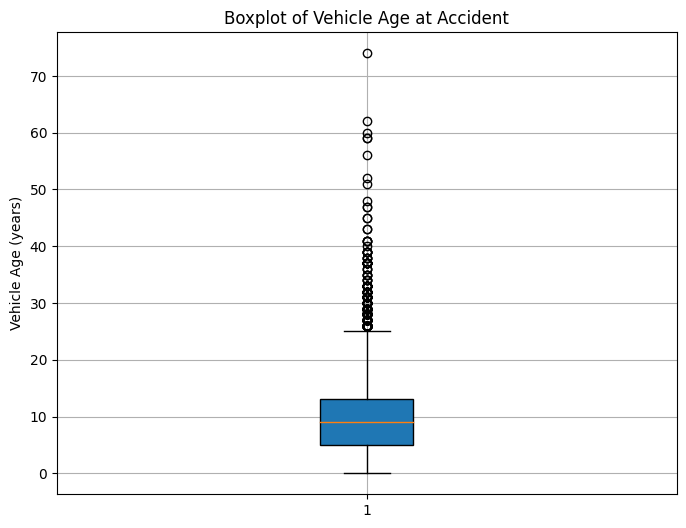

In [ ]:
import matplotlib.pyplot as plt

# Drop rows with missing or invalid age_of_vehicle
age_data = merged_df['age_of_vehicle'].dropna()

plt.figure(figsize=(8, 6))
plt.boxplot(age_data, vert=True, patch_artist=True)
plt.title('Boxplot of Vehicle Age at Accident')
plt.ylabel('Vehicle Age (years)')
plt.grid(True)
plt.show()


In [ ]:
# Convert model_year to numeric if it's not already (ignore non-numeric like 'Unknown')
model_year_numeric = pd.to_numeric(merged_df['model_year'], errors='coerce')

# Drop NaNs caused by invalid values
model_year_clean = model_year_numeric.dropna()

# Get range
min_year = model_year_clean.min()
max_year = model_year_clean.max()

print(f"Model year range: {int(min_year)} to {int(max_year)}")


Model year range: 1945 to 2023


**Updated Columns to Keep**

In [ ]:
# Drop the specified columns
columns_to_keep = ['accident_index', 'accident_reference', 
           'accident_severity', 'date', 'time', 
           'road_type', 'speed_limit', 'light_conditions', 
            'weather_conditions', 'road_surface_conditions',
            'vehicle_manoeuvre', 
             'hit_object_in_carriageway',
             'first_point_of_impact',  
             'city', 'state', 'country', 'latitude', 'longitude', 
             'make', 'model', 'model_year']
# Drop all columns except the ones specified in columns_to_keep
merged_df = merged_df[columns_to_keep]

print(tabulate(merged_df.head(10), headers='keys', tablefmt='grid', showindex=True))

+-----+------------------+----------------------+---------------------+---------------------+----------+--------------------+---------------+-----------------------+----------------------+---------------------------+-------------------------+-----------------------------+-------------------------+----------------+---------+----------------+------------+-------------+------------+----------+--------------+
|     |   accident_index |   accident_reference | accident_severity   | date                | time     | road_type          |   speed_limit | light_conditions      | weather_conditions   | road_surface_conditions   | vehicle_manoeuvre       | hit_object_in_carriageway   | first_point_of_impact   | city           | state   | country        |   latitude |   longitude | make       | model    |   model_year |
+=====+==================+======================+=====================+=====================+==========+====================+===============+=======================+=================

## **<span style="color:lightblue;">Standardising Values and Rows to match US </span>**

**Renaming Columns to match US NHTSA Dataset**

In [ ]:
# Define a dictionary to map old column names to new column names
column_rename_mapping = {
    'accident_index': 'Report ID',
    'accident_reference': 'Report Version',
    'make': 'Make',
    'model': 'Model',
    'model_year': 'Model Year',
    'date': 'Incident Date',
    'time': 'Incident Time (24:00)',
    'city': 'City',
    'state': 'State',
    'country': 'Country',
    'road_type': 'Roadway Type',
    'road_surface_conditions': 'Roadway Surface',
    'speed_limit': 'Posted Speed Limit (MPH)',
    'light_conditions': 'Lighting',
    'hit_object_in_carriageway': 'Crash With',
    'accident_severity': 'Highest Injury Severity Alleged',
    'vehicle_manoeuvre': 'SV Pre-Crash Movement',
    'weather_conditions': 'Weather',
    'first_point_of_impact': 'SV Contact Area'
}

# Rename the columns in the DataFrame
merged_df.rename(columns=column_rename_mapping, inplace=True)

# Display the updated DataFrame
print("Updated DataFrame with renamed columns:")
print(tabulate(merged_df.head(10), headers='keys', tablefmt='grid', showindex=True))

Updated DataFrame with renamed columns:
+-----+---------------+------------------+-----------------------------------+---------------------+-------------------------+--------------------+----------------------------+-----------------------+--------------------+-------------------+-------------------------+--------------+-------------------+----------------+---------+----------------+------------+-------------+------------+----------+--------------+
|     |     Report ID |   Report Version | Highest Injury Severity Alleged   | Incident Date       | Incident Time (24:00)   | Roadway Type       |   Posted Speed Limit (MPH) | Lighting              | Weather            | Roadway Surface   | SV Pre-Crash Movement   | Crash With   | SV Contact Area   | City           | State   | Country        |   latitude |   longitude | Make       | Model    |   Model Year |
+=====+===============+==================+===================================+=====================+=========================+========

**Dropping Lattitude and Longitude**


In [ ]:
# Drop the 'latitude' and 'longitude' columns
# merged_df = merged_df.drop(columns=['latitude', 'longitude'])

**Add the rows from US AV to show non autonomous**

In [ ]:

# Add rows for ADS Equipped and Automation System Engaged
merged_df['ADS Equipped?'] = 'Conventional'
merged_df['Automation System Engaged?'] = 'Conventional'


**Rename the values to match US Names**

In [ ]:
# Renaming values in the "Highest Injury Severity Alleged" column of merged_df
merged_df['Highest Injury Severity Alleged'] = merged_df['Highest Injury Severity Alleged'].replace({
    'Fatal': 'Fatality',
    'Slight': 'Minor'
})

merged_df['SV Pre-Crash Movement'] = merged_df['SV Pre-Crash Movement'].replace({
    'Turning left': 'Making Left Turn',
    'Turning right': 'Making Right Turn',
    'Reversing': 'Backing',
    'Slowing or stopping': 'Stopping',
    'U-turn': 'Making U-Turn',
    'Chnaging lane to right': 'Changing Lanes',
    'Chnaging lane to left': 'Changing Lanes',
    'Going ahead left-hand bend': 'Travelling around Bend',
    'Going ahead right-hand bend': 'Travelling around Bend',
      
})

merged_df['Lighting'] = merged_df['Lighting'].replace({
    'Darkness - lights lit': 'Dark - Lighted',
    'Darkness - no lighting': 'Dark - Not Lighted',
    'Darkness - lighting unknown': 'Dark - Unknown Lighting',
})

merged_df['Crash With'] = merged_df['Crash With'].replace({
    'Other object': 'Other Fixed Object',
    'Any animal (except ridden horse)': 'Animal',
})

merged_df['Roadway Surface'] = merged_df['Roadway Surface'].replace({
    'Frost or ice': 'Snow / Slush / Ice',
    'Snow': 'Snow / Slush / Ice',
    'Wet or damp': 'Wet',
})

merged_df['Weather'] = merged_df['Weather'].replace({
    'Fine no high winds': 'Clear',
    'Fine + high winds': 'Clear',
})

merged_df['Crash With'] = merged_df['Crash With'].replace({
    'None': 'No Object', # pandas mapping none as nan
})
merged_df.head(10)

,Report ID,Report Version,Highest Injury Severity Alleged,Incident Date,Incident Time (24:00),Roadway Type,Posted Speed Limit (MPH),Lighting,Weather,Roadway Surface,...,City,State,Country,latitude,longitude,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?
15,2019010155206,10155206,Minor,2019-01-01,01:15:00,Single carriageway,30.0,Dark - Lighted,Clear,Dry,...,Chadwell Heath,England,United Kingdom,51.572326,0.141957,SUZUKI,SWIFT,2015,Conventional,Conventional
23,2019010155217,10155217,Serious,2019-01-01,04:10:00,Dual carriageway,40.0,Dark - Lighted,Clear,Dry,...,Ilford,England,United Kingdom,51.557075,0.070277,HYUNDAI,I30,2015,Conventional,Conventional
105,2019010155425,10155425,Minor,2019-01-02,15:07:00,Single carriageway,20.0,Daylight,Clear,Dry,...,Stamford Hill,England,United Kingdom,51.561751,-0.078765,MERCEDES,C CLASS,2018,Conventional,Conventional
620,2019010156538,10156538,Minor,2019-01-08,21:20:00,Single carriageway,20.0,Dark - Lighted,Clear,Dry,...,Goodmayes,England,United Kingdom,51.545376,0.106077,TOYOTA,AVENSIS,2005,Conventional,Conventional
733,2019010156721,10156721,Serious,2019-01-10,08:20:00,Dual carriageway,30.0,Daylight,Clear,Dry,...,South Norwood,England,United Kingdom,51.396245,-0.069305,AUDI,A4,2017,Conventional,Conventional
760,2019010156785,10156785,Minor,2019-01-10,17:40:00,Dual carriageway,30.0,Dark - Lighted,Clear,Snow / Slush / Ice,...,Woolwich,England,United Kingdom,51.490772,0.072717,FORD,GALAXY,2002,Conventional,Conventional
779,2019010156813,10156813,Minor,2019-01-10,19:30:00,Dual carriageway,30.0,Dark - Lighted,Clear,Dry,...,Whitechapel,England,United Kingdom,51.50937,-0.063532,VOLKSWAGEN,GOLF,2011,Conventional,Conventional
783,2019010156821,10156821,Serious,2019-01-10,17:40:00,Single carriageway,20.0,Dark - Lighted,Clear,Dry,...,West Wickham,England,United Kingdom,51.340228,-0.013811,FORD,STREETKA,2004,Conventional,Conventional
876,2019010156988,10156988,Serious,2019-01-11,16:15:00,Dual carriageway,30.0,Daylight,Clear,Dry,...,Cricklewood,England,United Kingdom,51.557241,-0.214474,BMW,3 SERIES,1997,Conventional,Conventional
972,2019010157153,10157153,Minor,2019-01-12,15:08:00,Single carriageway,30.0,Daylight,Clear,Dry,...,Palmers Green,England,United Kingdom,51.621479,-0.133914,FORD,FIESTA,2002,Conventional,Conventional


In [ ]:
# Count 'unknown' (case-insensitive)
unknown_counts = merged_df.apply(
    lambda col: col.astype(str).str.strip().str.lower().eq('unknown').sum()
)

# Count missing (NaN) + empty strings
missing_counts = merged_df.apply(
    lambda col: col.isna().sum() + col.astype(str).str.strip().eq('').sum()
)

# Combine into a summary DataFrame
summary_df = pd.DataFrame({
    'column': merged_df.columns,
    'unknown_count': unknown_counts.values,
    'missing_or_empty_count': missing_counts.values
})

# Sort by total issue count
summary_df['total_problematic'] = summary_df['unknown_count'] + summary_df['missing_or_empty_count']
summary_df = summary_df.sort_values(by='total_problematic', ascending=False)

# Display final summary table
print("🔍 Count of 'unknown' and missing/empty values per column:")
print(summary_df[['column', 'unknown_count', 'missing_or_empty_count']])


🔍 Count of 'unknown' and missing/empty values per column:
                             column  unknown_count  missing_or_empty_count
0                         Report ID              0                       0
12                  SV Contact Area              0                       0
21                    ADS Equipped?              0                       0
20                       Model Year              0                       0
19                            Model              0                       0
18                             Make              0                       0
17                        longitude              0                       0
16                         latitude              0                       0
15                          Country              0                       0
14                            State              0                       0
13                             City              0                       0
11                       Crash With       

In [ ]:
# chnage column order
desired_order = [
    'Report ID', 'Report Version', 'Make', 'Model', 'Model Year', 'ADS Equipped?',
    'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'City',
    'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting',
    'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement',
    'Weather', 'SV Contact Area', 'Country', 'latitude', 'longitude'
]

# Reorder your dataframe columns
merged_df = merged_df[desired_order]


## **<span style="color:lightblue;">Save Cleaned Dataset </span>**

**Save Cleaned Dataset**

In [ ]:
merged_df.to_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv', index=False)